# First Attempt at Time Series

* Garrett Arnett

## Our Goal
* Create a time series model which will predict revenue on a sales database


## Our Plan

Plan: Questions and Hypotheses

Acquire: Obtain dataset

Prepare: Kept outliers, missingness was a non-issue, as there were ZERO entries containing NULL values for 
predictors. Split into ML subsets (Train/Validate/Test).

Explore: Find coorelations.

Model: Modeled dataset via moving averages, previous years.

## Imports


In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt

import seaborn as sns

import wrangle as wr
import modeling as mo

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 
from scipy import stats

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

from datetime import timedelta, datetime
from statsmodels.tsa.arima.model import ARIMA

# Plt defaults
# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(14, 8))
plt.rc('font', size=16)
import seaborn as sns; sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Acquire and Data Preperation

Dataset from: https://www.kaggle.com/datasets/thedevastator/analyzing-customer-spending-habits-to-improve-sa?resource=download

* Acquire: Obtain dataset from kaggle https://www.kaggle.com/datasets/thedevastator/analyzing-customer-spending-habits-to-improve-sa

* Prepare: Kept outliers, deleted cells with NAN/null. Split into ML subsets. Created numerical values for country, state, product, and sub category column. (Train/Validate/Test) dataset for model predicitons.


In [2]:
df = wr.wrangle()

In [3]:
df.head()

,Date,Year,Month,Day,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,Year_Month,Margin,Unit_Margin
0,2015-01-01,2015.0,1,1,37.0,0,4,1,1,0,2.0,1091.0,1272.500000,2182.0,2545.0,2015-01,363.0,181.500000
1,2015-01-01,2015.0,1,1,19.0,0,1,2,1,0,1.0,1000.0,938.000000,1000.0,938.0,2015-01,-62.0,-62.000000
2,2015-01-01,2015.0,1,1,29.0,0,1,3,1,0,3.0,261.0,230.666667,783.0,692.0,2015-01,-91.0,-30.333333
3,2015-01-01,2015.0,1,1,29.0,1,1,4,1,0,3.0,261.0,233.000000,783.0,699.0,2015-01,-84.0,-28.000000
4,2015-01-01,2015.0,1,1,36.0,0,1,5,1,1,2.0,1035.5,896.000000,2071.0,1792.0,2015-01,-279.0,-139.500000


In [4]:
train, validate, test = mo.model()

## Explore

### Does country coorelate with revenue?

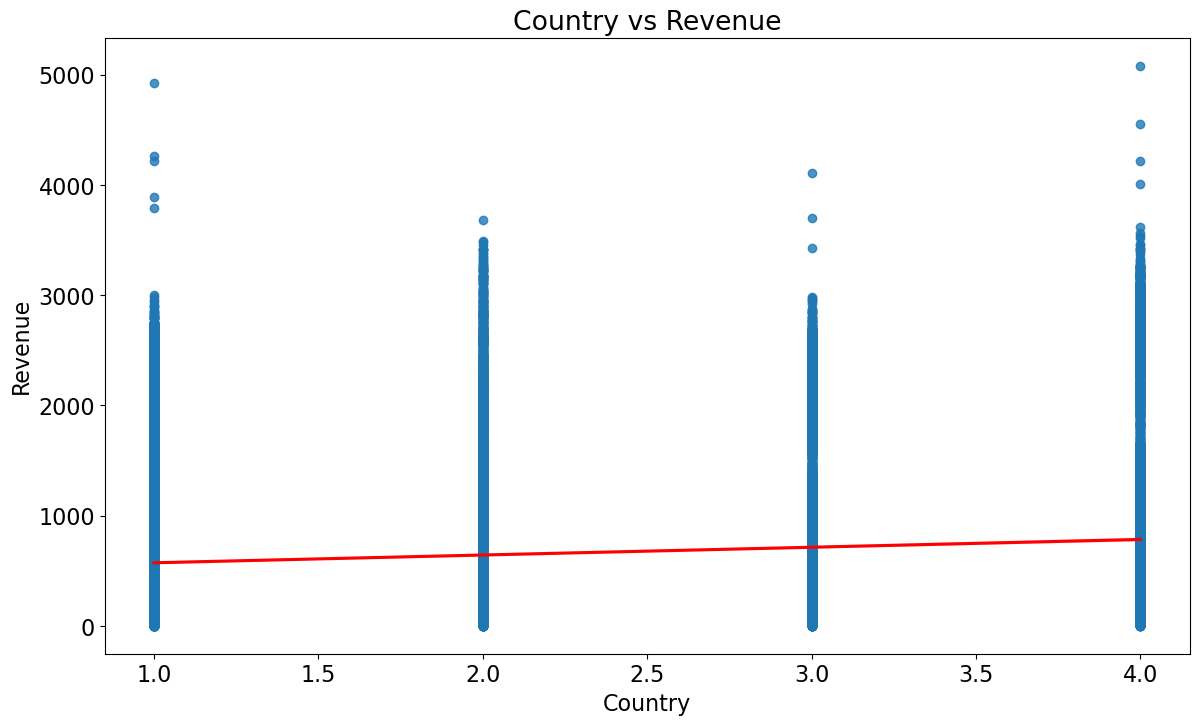

REJECT NULL HYPOTHESIS!
Correlation: 0.0870
P-Value: 0.0000


In [11]:
    sns.regplot(data=df, x='Country', y='Revenue', line_kws={'color':'red'})
    plt.title('Country vs Revenue')
    plt.show()
    r, p = stats.spearmanr(df['Country'], df['Revenue'])
    alpha = 0.05
    if p < alpha:
        print(f'\033[32mREJECT NULL HYPOTHESIS!\033[0m')
        print(f'\033[35mCorrelation:\033[0m {r:.4f}')
        print(f'\033[35mP-Value:\033[0m {p:.4f}')
    else:
        print(f'\033[31mACCEPT NULL HYPOTHESIS!\033[0m')
        print(f'\033[35mCorrelation:\033[0m {r:.4f}')
        print(f'\033[35mP-Value:\033[0m {p:.4f}')

### Does the product coorelate with revenue?

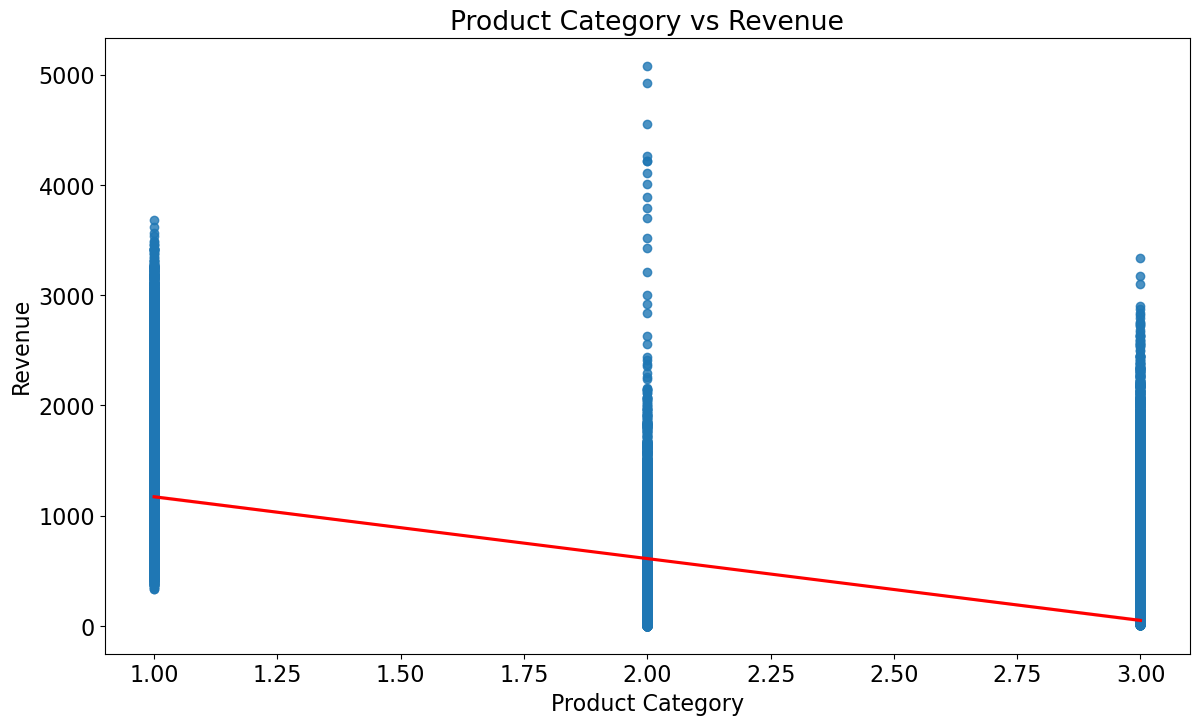

REJECT NULL HYPOTHESIS!
Correlation: -0.3608
P-Value: 0.0000


In [12]:
    sns.regplot(data=df, x='Product Category', y='Revenue', line_kws={'color':'red'})
    plt.title('Product Category vs Revenue')
    plt.show()
    r, p = stats.spearmanr(df['Product Category'], df['Revenue'])
    alpha = 0.05
    if p < alpha:
        print(f'\033[32mREJECT NULL HYPOTHESIS!\033[0m')
        print(f'\033[35mCorrelation:\033[0m {r:.4f}')
        print(f'\033[35mP-Value:\033[0m {p:.4f}')
    else:
        print(f'\033[31mACCEPT NULL HYPOTHESIS!\033[0m')
        print(f'\033[35mCorrelation:\033[0m {r:.4f}')
        print(f'\033[35mP-Value:\033[0m {p:.4f}')

## Modeling

#### I use four different regressors:

* Moving Average 
* Previous Cycle

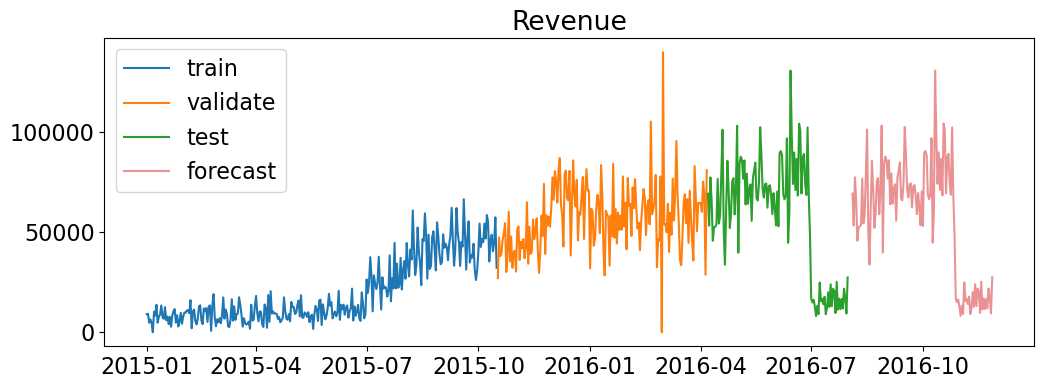

In [13]:
yhat_df = mo.yhat()
yhat_df = test + train.diff().mean()
yhat_df.index = test.index + pd.Timedelta('17W')
target_var = 'Revenue'
plt.figure(figsize=(12,4))
plt.plot(train[target_var], label='train')
plt.plot(validate[target_var], label='validate')
plt.plot(test[target_var], label='test')
plt.plot(yhat_df[target_var], alpha=.5, label='forecast')
plt.title(target_var)
plt.legend()
plt.show()
for col in train.columns:
    (col)

### Modeling Summary


Observation of prediction results led me to the following conclusions:
* Previous cycle was the best option. 
* Both Models did not produce reliability.


## Conclusions
* Our dataset is not the best when working with Time series analasys. 
* Our catboost model beat our baseline by 50%

## Next Steps
* Find different TSA models to help better predict Revenue
* Obtain more data about the customers which will help with better marketing stategies for the different countries.
